# Integrating out the noise in Gaussian likelihood problems



Create fake data for the logistic model.

In [1]:
import os
os.chdir("..")
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add noise
nu = 2
sigma = 10
observed_values_norm = signal_values + scipy.stats.norm.rvs(loc=0, scale=sigma, size=signal_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values_norm)

Fit the model using a Gaussian likelihood where we estimate the noise parameter $\sigma$.

Running...
Done!
R-hat:
[1.0023693510933953, 1.0030142729712659, 1.0007257580697624]


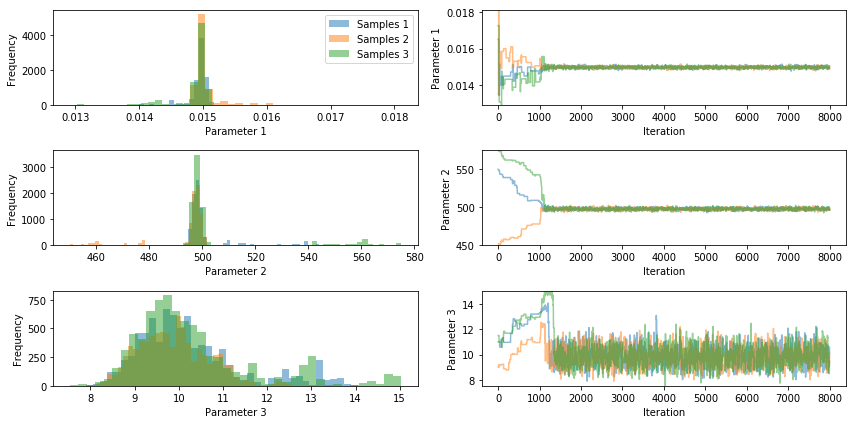

In [2]:
# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma*0.1],
    [0.02, 600, sigma*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters + [sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
]


# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_gaussian = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Now fitting the same model using a log-likelihood where the noise parameter $\sigma$ has been integrated out. Here the convergence to the stationary distribution is quicker.

Running...
Done!
R-hat:
[1.0009250985892084, 1.0000051353894825]


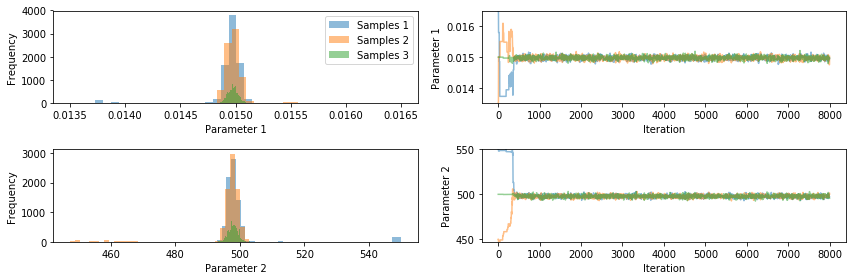

In [3]:
# Create a log-likelihood function with an upper value for the uniform prior on sigma
upper = 100
log_likelihood = pints.GaussianIntegratedUniformLogLikelihood(problem, upper)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters)
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.0,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(250)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_integrated = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show graphs
plt.show()

Comparing the marginal distributions for $r$ and $\kappa$ for the two models, they look similar.

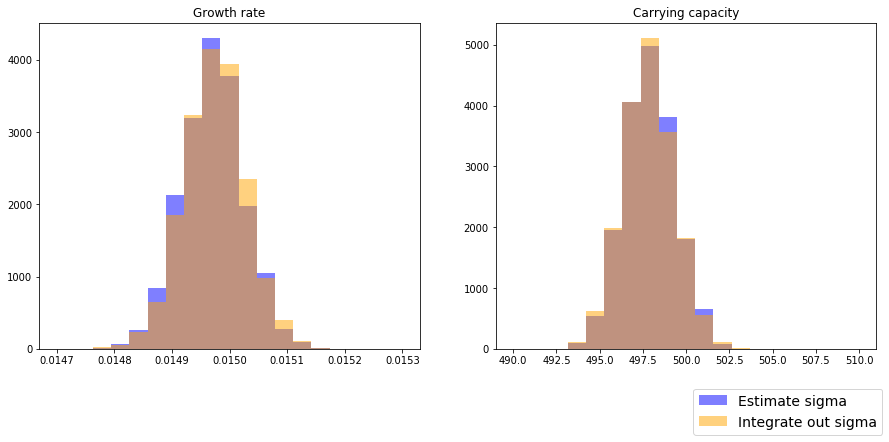

In [4]:
chains_gaussian1 = np.vstack(chains_gaussian)
chains_integrated1 = np.vstack(chains_integrated)

# plot
plt.figure(figsize=(15, 6)) 
plt.subplot(1, 2, 1)
bins = np.linspace(0.0147, 0.0153, 20)
plt.hist(chains_gaussian1[:, 0], bins, alpha=0.5, color="blue", label='Estimate sigma')
plt.hist(chains_integrated1[:, 0], bins, alpha=0.5, color="orange", label='Integrate out sigma')
plt.title("Growth rate")

plt.subplot(1, 2, 2)
bins = np.linspace(490, 510, 20)
plt.hist(chains_gaussian1[:, 1], bins, alpha=0.5, color="blue", label='Estimate sigma')
plt.hist(chains_integrated1[:, 1], bins, alpha=0.5, color="orange", label='Integrate out sigma')
plt.title("Carrying capacity")

plt.rc('font', size=14) 
plt.legend(loc="upper left", bbox_to_anchor=(0.5, -0.1))
plt.show()